In [4]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)
print(As)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    #"100*theta_s": 1.04,
    "H0": 67.66
}

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

######################################################
#  Configuring the run
######################################################



common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 1,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }

#LCDM parameters
for name, value in standard_params.items():
    common_settings.update({name: value})

pr_cover_tau = 0.004
precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
print(Class.__file__)

2.105209331337507e-09
/Users/gabe/.local/lib/python3.9/site-packages/classy-3.1.0-py3.9-macosx-10.9-x86_64.egg/classy.cpython-39-darwin.so


In [5]:
M.compute()

Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690267


# Standard $X_e(z)$ 

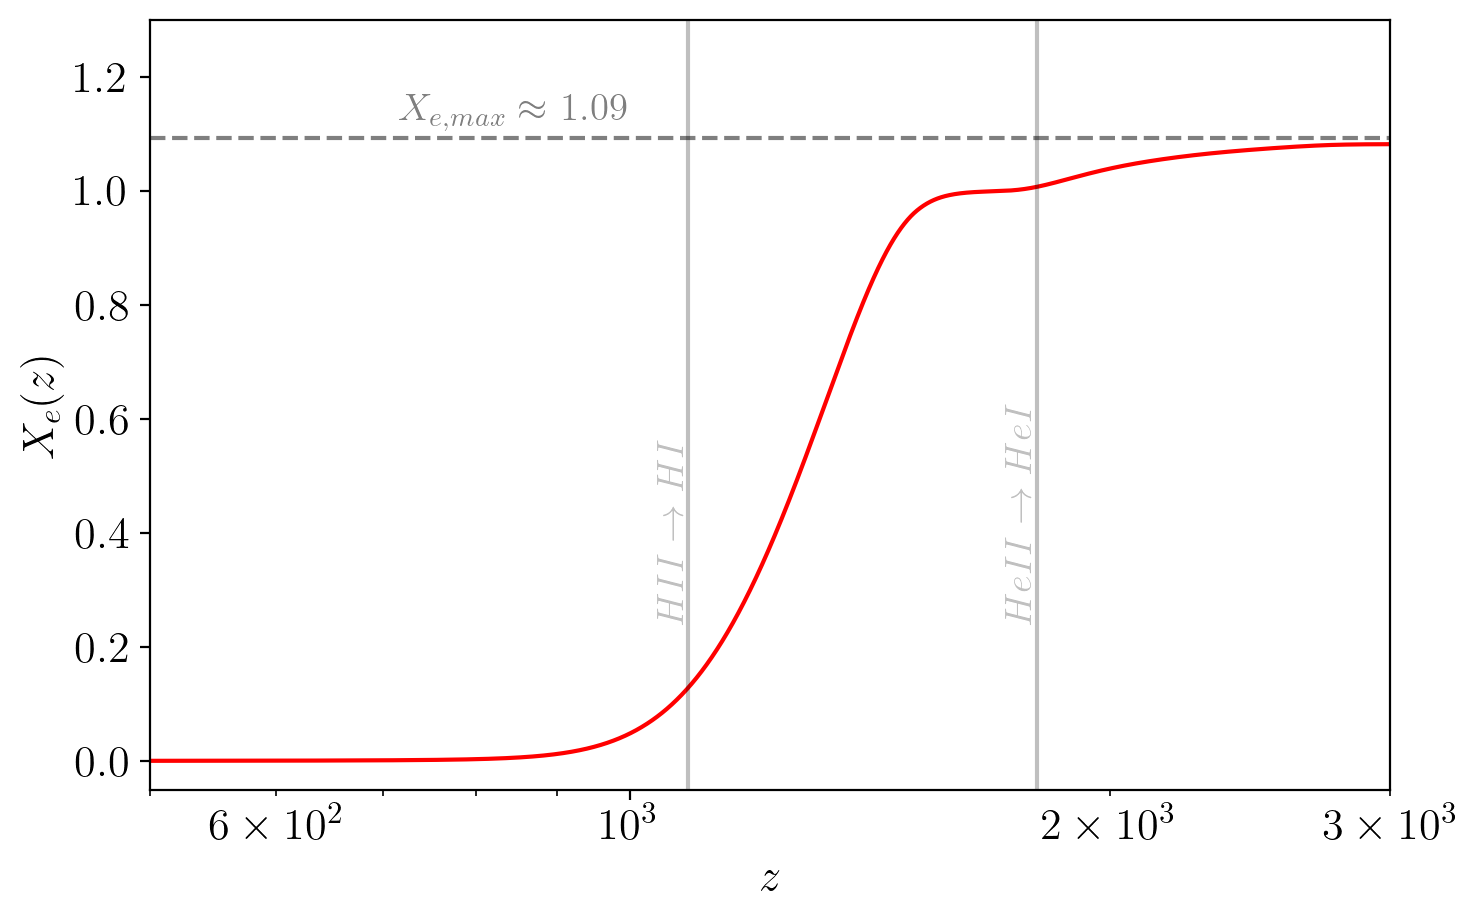

In [6]:
from scipy.interpolate import interp1d
fiducial_thermo = M.get_thermodynamics()
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
ll_max = 2500
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]

fiducial = fiducial_thermo["x_fid"]
fiducial_viz = fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"]
######################################################
######################################################

Yp = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max = 1 + Yp/2*(1-Yp)

######################################################
# Plots
######################################################

fig,ax=plt.subplots(figsize=(8,5))

ax.plot(fiducial_thermo['z'], fiducial_thermo['x_e'], color='red')
ax.set_xlim([500, 3000])
ax.set_ylim([-0.05, 1.3])
ax.axhline([[xe_max]], linestyle="dashed", color="black", alpha=0.5)
ax.text(0.2, 0.87, "$X_{{e,max}} \\approx$ {:.2f}".format(xe_max), fontsize=14, transform=ax.transAxes, alpha=0.5)

ax.axvline([1800], color="black", alpha=0.25)

ax.axvline([1088], color="black", alpha=0.25)
#ax.axvline([2500], color="black", alpha=0.25)

ax.text(1720, 0.25, "$HeII \\to HeI$", color="black", alpha=0.25, rotation=90, fontsize = 14)
ax.text(1040, 0.25, "$HII \\to HI$", color="black", alpha=0.25, rotation=90, fontsize = 14)

#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$z$', fontsize=fsize)
ax.set_ylabel('$X_e(z)$', fontsize=fsize)
plt.savefig("../results/standard_xe.jpg",dpi=300, bbox_inches='tight')
plt.show()


# Standard visibility function

Viz function has value 0.00021535009116132196 at index 5849 and redshift 1301.71
0.01*viz_max = 0.00021176890510036486
Viz function has value 0.00021141939680205241 at index 4575 and redshift 667.895
0.01*viz_max = 0.00021176890510036486


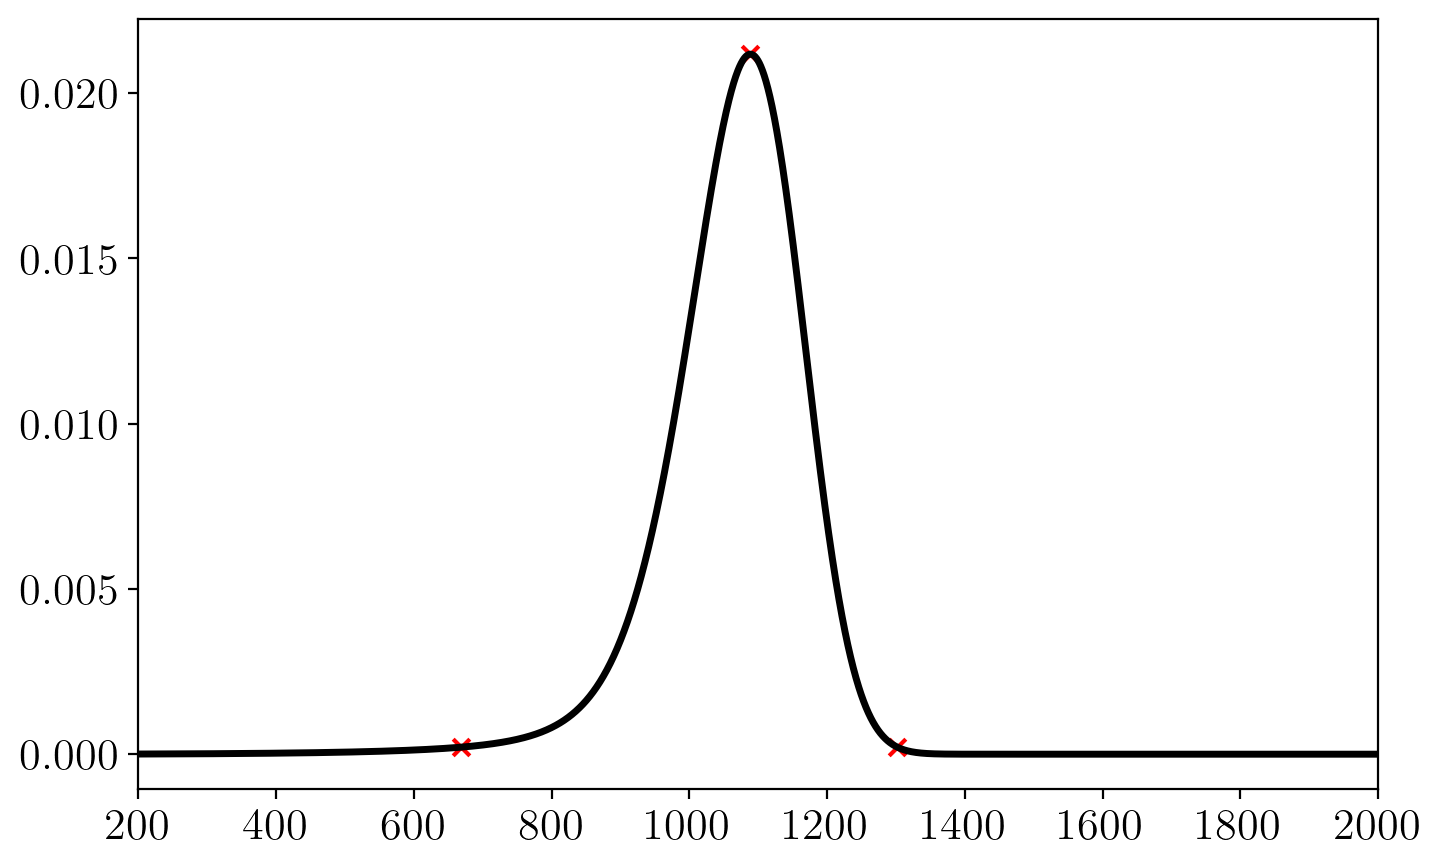

In [7]:
fig,ax = plt.subplots(figsize=(8,5))

ind_max = np.argmax(fiducial_viz)
max_viz = fiducial_viz[ind_max]

highz_percent_cutoff = 0.01
lowz_percent_cutoff = 0.01

test = np.where(fiducial_viz<highz_percent_cutoff*max_viz, 1, 0)
ind_highz = np.argwhere(np.diff(test)==1)[0][0]

test = np.where(fiducial_viz<lowz_percent_cutoff*max_viz, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]

print("Viz function has value {0} at index {1} and redshift {2}".format(fiducial_viz[ind_highz], ind_highz, fiducial_thermo['z'][ind_highz]))
print("{0:.2f}*viz_max = {1}".format(highz_percent_cutoff, highz_percent_cutoff*max_viz))

print("Viz function has value {0} at index {1} and redshift {2}".format(fiducial_viz[ind_lowz], ind_lowz, fiducial_thermo['z'][ind_lowz]))
print("{0:.2f}*viz_max = {1}".format(lowz_percent_cutoff, lowz_percent_cutoff*max_viz))

ax.plot(fiducial_thermo['z'], fiducial_viz, linewidth=2.5, color="black")
ax.scatter(fiducial_thermo['z'][ind_max], fiducial_viz[ind_max], marker="x", color="red")
ax.scatter(fiducial_thermo['z'][ind_highz], fiducial_viz[ind_highz], marker="x", color="red")
ax.scatter(fiducial_thermo['z'][ind_lowz], fiducial_viz[ind_lowz], marker="x", color="red")
ax.set_xlim([200, 2000])

plt.show()

# Perturbations with CLASS


In [8]:
#######################################################
# Perturbation parameters
######################################################
num_control_points = 4
free_pivots = np.linspace(start=np.floor(fiducial_thermo['z'][ind_lowz]), stop=np.floor(fiducial_thermo['z'][ind_highz]), num=num_control_points)
dz_pivot = np.diff(free_pivots)[0]
zmin_pert = free_pivots[0] - dz_pivot
zmax_pert = free_pivots[-1] + dz_pivot

print(zmin_pert)

pivots = np.insert(free_pivots, 0, zmin_pert)
pivots = np.append(pivots, zmax_pert)

str_pivots = ["{:.4f}".format(p) for p in pivots]
str_pivots = ",".join(str_pivots)
print(str_pivots)
#######################################################
# Setting up CLASS for perturbed run
######################################################

fine_grid = np.linspace(zmin_pert, zmax_pert, 100)

common_settings = {'output' : 'tCl,pCl,lCl',
                   'reio_parametrization': 'reio_camb',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': num_control_points+2,
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   'xe_control_pivots': str_pivots
                  }

#LCDM parameters
for name, value in standard_params.items():
    common_settings.update({name: value})

precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

686.3333333333334
686.3333,820.0000,953.6667,1087.3333,1221.0000,1354.6667


True

# Single example

# Multiple example

In [9]:
num_of_functions = 20
gaussian_scale = .3

zs = []
xe_funcs = []
viz_funcs = []
cmb_tt_spectra = []

print(str_pivots)
for i in np.arange(num_of_functions):
    control_points = np.random.normal(loc=0.0, scale=gaussian_scale, size=num_control_points)
    #control_points = np.random.uniform(low=-1*gaussian_scale, high=gaussian_scale, size=num_control_points)
    control_points = np.insert(control_points, 0, 0.0)
    control_points = np.append(control_points, 0.0)
    str_ctrl = [str(c) for c in control_points]
    print("xe_control_points: '{}'".format(",".join(str_ctrl)))
    M.set({"xe_control_points": ",".join(str_ctrl)})
    M.compute()
    Tcmb = M.T_cmb()*10**6 
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:]
    thermo = M.get_thermodynamics()
    zs.append(thermo["z"])
    xe_funcs.append(thermo["x_fid"]+thermo['xe_pert'])
    viz_funcs.append(thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"])
    cmb_tt_spectra.append(ll*(ll+1)/(2*np.pi)*tt)


686.3333,820.0000,953.6667,1087.3333,1221.0000,1354.6667
xe_control_points: '0.0,-0.39482792022860935,-0.054109800549371395,-0.25470320579090233,-0.02110170886980528,0.0'
xe_control_points: '0.0,-0.12464527214105893,0.21868041327307475,-0.13548347539883868,0.4311001229056716,0.0'
xe_control_points: '0.0,-0.3272065886755697,-0.06636316111570058,0.27254578474554203,0.46204314712108874,0.0'
xe_control_points: '0.0,0.2897584661488384,-0.3016918359851028,0.37332046349869924,0.17170507426127166,0.0'
xe_control_points: '0.0,-0.3313219026469749,-0.15035523878358673,-0.04288838943176055,0.21499208454595173,0.0'
xe_control_points: '0.0,-0.07748151454325689,-0.03975543152268567,-0.34034122401360395,-0.6624438900027971,0.0'
xe_control_points: '0.0,-0.2950738649272961,0.36919898784080635,0.28792995764109675,-0.06343290771210185,0.0'
xe_control_points: '0.0,0.34691469861273516,0.03328518192671986,-0.17220872211295649,-0.40194723462630405,0.0'
xe_control_points: '0.0,0.37889164944516934,-0.3015004345

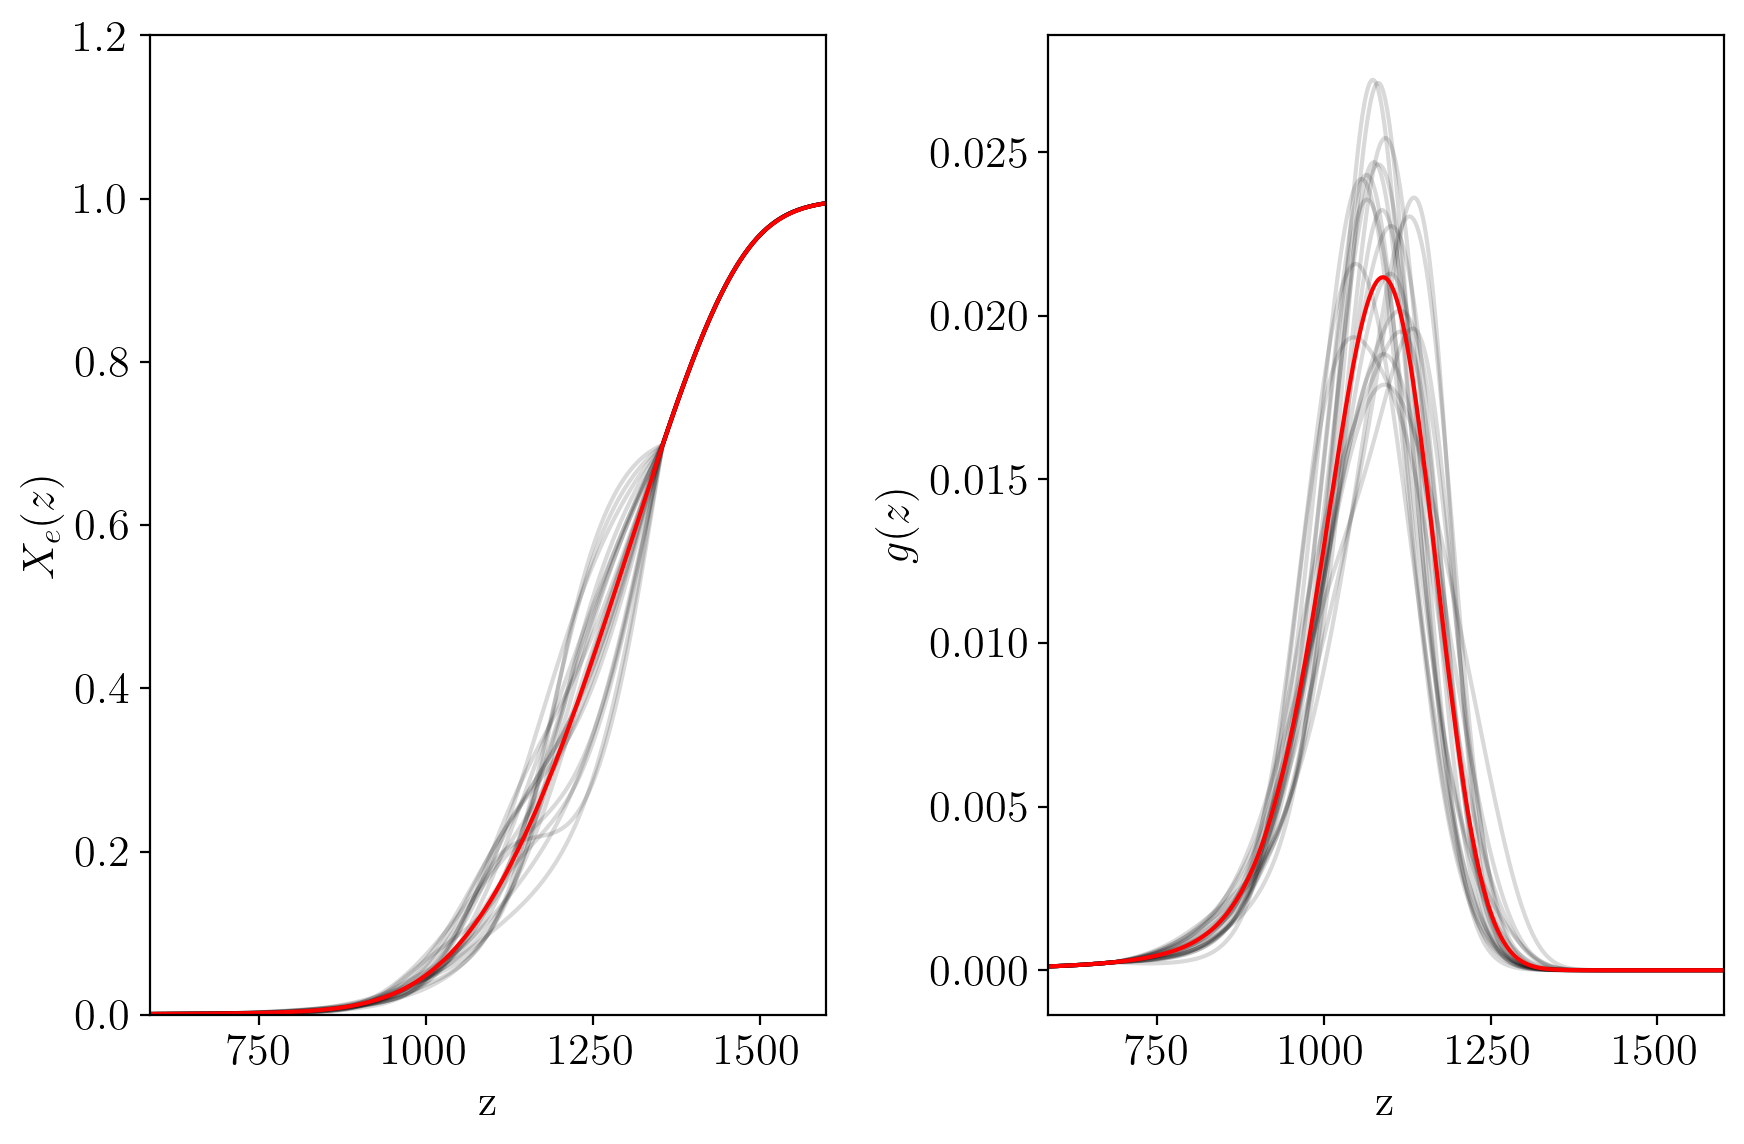

In [10]:
fig,ax=plt.subplots(1, 2, figsize=(9,6))
plt.subplots_adjust(wspace=0)

#ax.text(0.2, 0.65, "$X_{{e,max}} \\approx$ {:.2f}".format(xe_max), fontsize=14, transform=ax.transAxes, alpha=0.5)
#ax.set_xscale('log')
ax[1].set_xlabel('z', fontsize=fsize)
ax[0].set_xlabel('z', fontsize=fsize)

ax[0].set_ylabel('$X_e(z)$', fontsize=fsize)
ax[1].set_ylabel('$g(z)$', fontsize=fsize)

for i in np.arange(num_of_functions):
    ax[0].plot(zs[i], xe_funcs[i], color="black", alpha=0.15)
    ax[1].plot(zs[i], viz_funcs[i], color="black", alpha=0.15)

ax[0].plot(fiducial_thermo["z"], fiducial_thermo["x_e"], color="red")
ax[0].set_xlim([zmin_pert-100, zmax_pert+100])
ax[0].set_ylim([0, 1.2])
ax[1].plot(fiducial_thermo["z"], fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"], color="red")
ax[0].set_xlim([zmin_pert-100, 1600])
ax[1].set_xlim([zmin_pert-100, 1600])

plt.tight_layout()
#plt.savefig("../results/control_point_1_example.jpg",dpi=300, bbox_inches='tight')
plt.show()

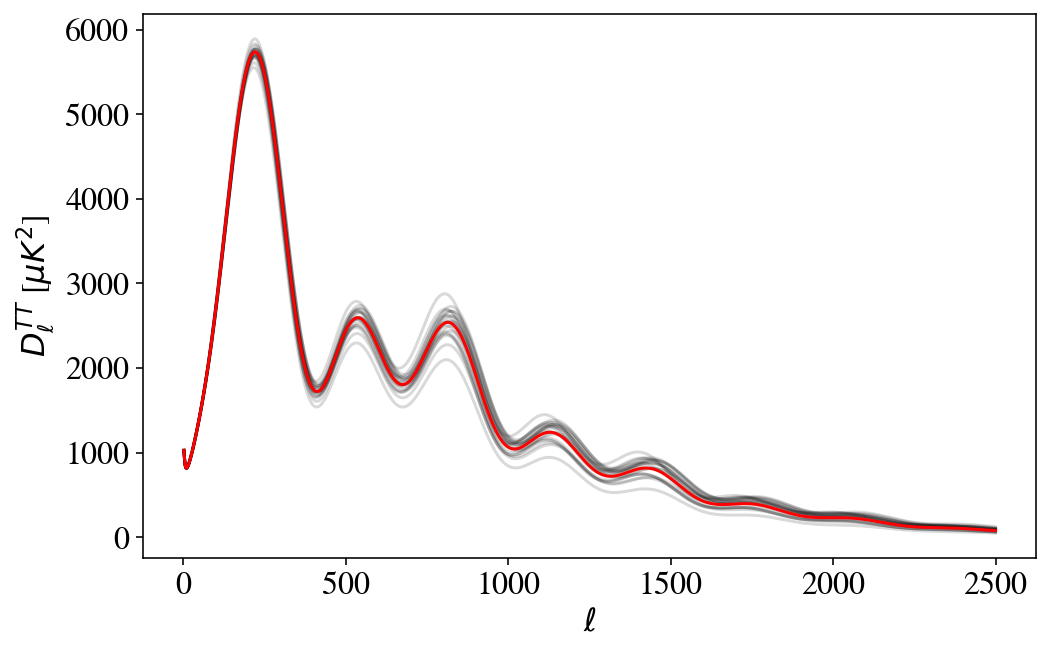

In [28]:
fig,ax = plt.subplots(figsize=(8,5))
for i in np.arange(num_of_functions):
    ax.plot(ll, cmb_tt_spectra[i], color="black", alpha=0.15)
ax.plot(ll, ll*(ll+1)/(2*np.pi)*tt_fid, color="red")
ax.set_xlabel("$\ell$", fontsize=16)
ax.set_ylabel("$D^{TT}_\ell$ [$\mu K^2$]")
plt.savefig("../results/D_ell_example.jpg",dpi=300, bbox_inches='tight')
plt.show()

# Generate proposal covariance matrix

In [7]:
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
from RecTools import *

#######################################################
# Fisher Matrix parameters
######################################################

basename = "mcmc5"

noise_parameters = {'beam_FWHM_143_arcmin' : 7.3,
                        'beam_FWHM_217_arcmin' : 4.90,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.8,
                        'use_143' : True,
                        'use_217' : True
                        }  

recombination_params = {"zmin_pert": zmin_pert,
                        "zmax_pert": zmax_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        'xe_pert_type': 'control',
                        "noise_params": noise_parameters,
                        "xe_control_pivots": str_pivots,
                        "inc_percentage": 0.05
                        }

target_params = [*standard_params.keys(), "xe_control_points"]

In [8]:
RecHistory = RecFisher(standard_params, recombination_params, basename)
path = RecHistory.filebase
RecHistory.compute_Fisher(target_params)

Created directory /Users/gabe/projects/recombination/data/Sep04.mcmc5.0
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', '100*theta_s', 'xe_control_points']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
100*theta_s
q_1
q_2
q_3
q_4
Fisher matrices calculation completed at 09/04/2022, 13:06:30


['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', '100*theta_s', 'q_1', 'q_2', 'q_3', 'q_4']


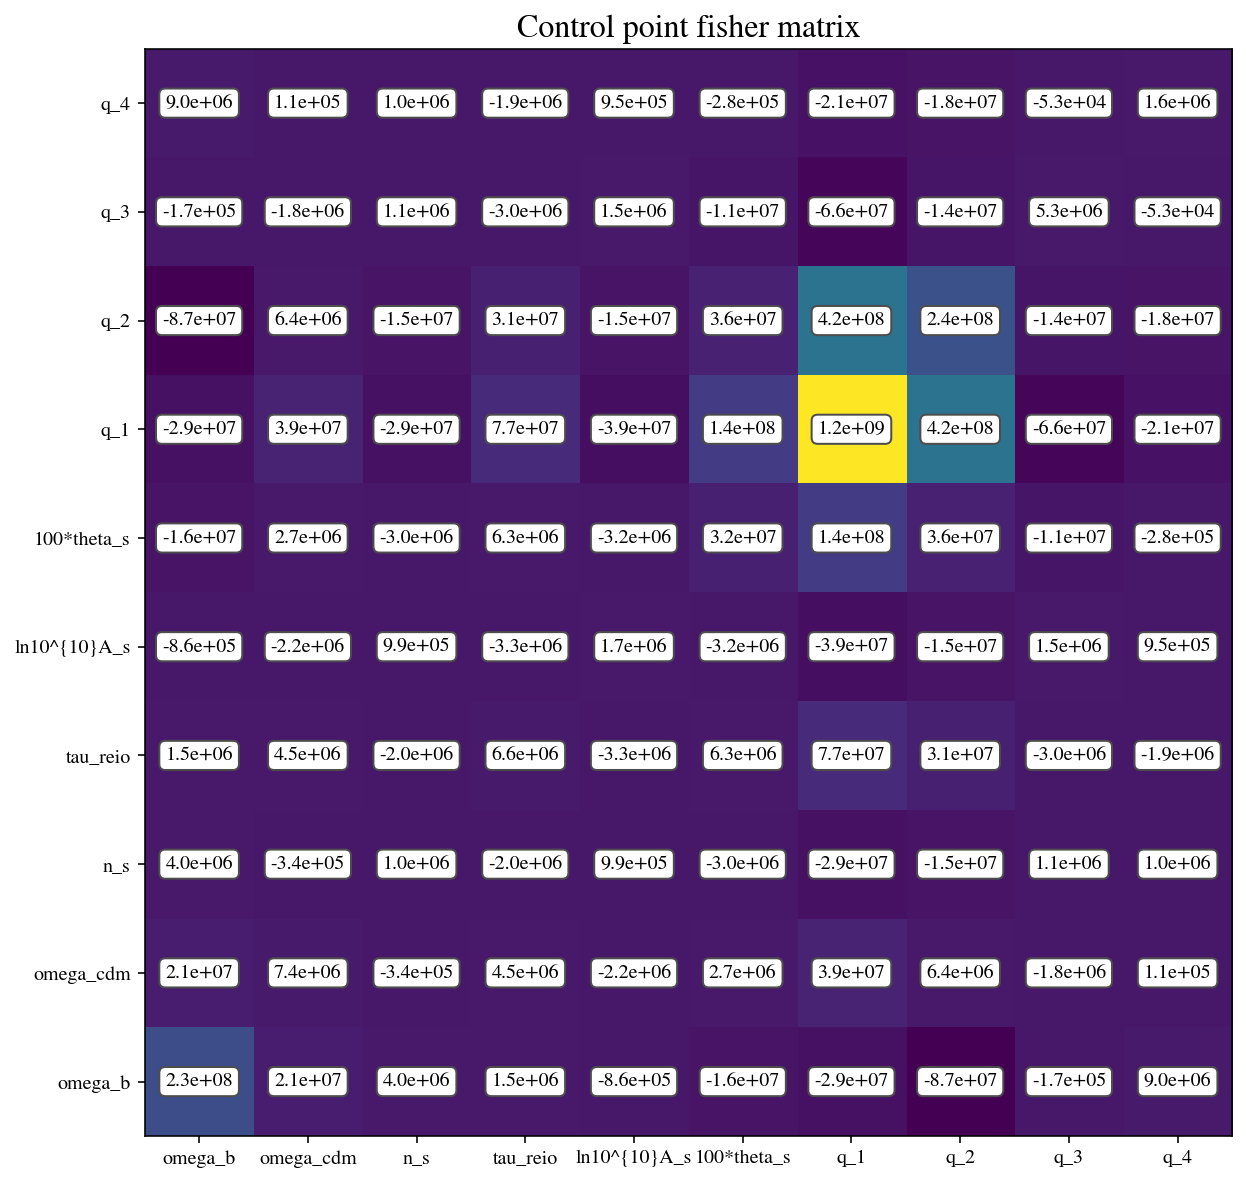

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib import cm

Fisher = FisherData(path)

scale=1
vsize = scale*10
hsize = scale*10

fig,ax = plt.subplots(figsize=(vsize,hsize))
cols = str(Fisher.col_names).split(",")
print(cols)
xtick_list = cols
ytick_list = cols
m=ax.imshow(Fisher.Fisher_full, origin='lower', cmap=cm.viridis)
for (i, j), z in np.ndenumerate(Fisher.Fisher_full):
    ax.text(j, i, '{:0.1e}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

divider = make_axes_locatable(ax)

ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(xtick_list)
ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(xtick_list)

ax.set_title("Control point fisher matrix", fontsize=16)

plt.show()

# omega_b omega_cdm n_s tau_reio logA theta_s_1e2 q_1 q_2 q_3 q_4


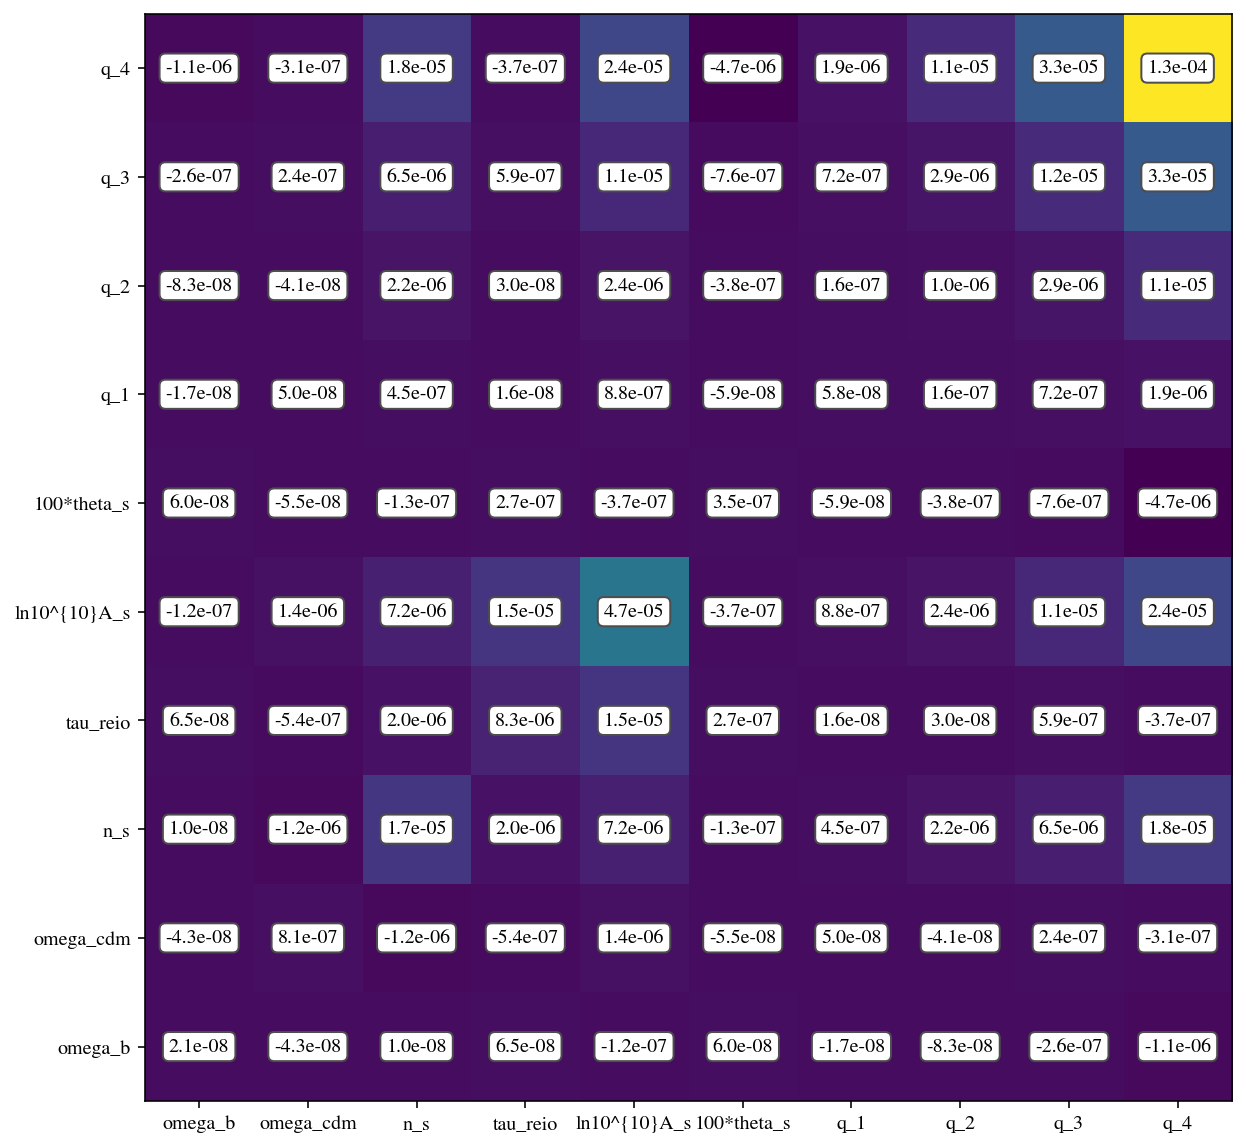

In [19]:
covmat_filename = "{}.prop.covmat".format(basename)
proposal_covmat = np.linalg.inv(Fisher.Fisher_full)
i = 1

fig,ax = plt.subplots(figsize=(vsize,hsize))
m=ax.imshow(proposal_covmat, origin='lower', cmap=cm.viridis)

for (i, j), z in np.ndenumerate(proposal_covmat):
    ax.text(j, i, '{:0.1e}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(xtick_list)
ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(xtick_list)


label_dict = {
    "omega_b": "omega_b",
    "omega_cdm": "omega_cdm",
    "ln10^{10}A_s": "logA",
    "tau_reio": "tau_reio",
    "100*theta_s": "theta_s_1e2",
    "n_s": "n_s",
}

for i in np.arange(1, len(pivots)):
    s = "q_%i" % i 
    label_dict.update({s: s})

header_string = "#"
for p in cols:
    header_string+=" {}".format(label_dict[p])

print(header_string)

write_file = False
if(write_file):
    with open(covmat_filename, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write(header_string+"\n")
        
        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for row in proposal_covmat:
            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places. 
            outfile.write(" ".join("{:.8e}".format(x) for x in row) + "\n") 
            #outfile.write('\n')

plt.show()

# Generate Cobaya input file


In [11]:
import yaml

data = {
    'theory': {
        'classy': {
            'path': "/home/gplynch/projects/class_h0",
            'ignore_obsolete': True,
            'extra_args': {
                'xe_pert_type': "control",
                'lensing': "yes",
                'start_sources_at_tau_c_over_tau_h': pr_cover_tau,
                'zmin_pert': float(zmin_pert),
                'zmax_pert': float(zmax_pert),
                'xe_pert_num': len(pivots),
                'xe_control_pivots': str(str_pivots),
                'output': "tCl,pCl,lCl"
            }
        }
    },
    'likelihood': {
      'planck_2018_lowl.TT': "null",
      'planck_2018_lowl.EE': "null",
      'planck_2018_highl_plik.TTTEEE_lite': "null",
      'planck_2018_lensing.clik': "null"
    },
    'params': {
        'logA': {
            'prior': {
                'min': 1.61,
                'max': 3.91
            },
            'ref': {
                'dist': "norm",
                'loc': 3.05,
                'scale': 0.001
            },
            'proposal': 0.001,
            'latex': '\log(10^{10} A_\mathrm{s})',
            'drop': True
        },
        "A_s": {
            'value': 'lambda logA: 1e-10*np.exp(logA)',
            'latex': "A_\mathrm{s}"
        },
        "n_s":{
            'prior': {
                'min': 0.8,
                'max': 1.2
            },
            'ref': {
                'dist': "norm",
                'loc': 0.965,
                'scale': 0.004
            },
            'proposal': 0.002,
            'latex': "n_\mathrm{s}"
        },
        "theta_s_1e2": {
            'prior': {
                'min': 0.5,
                'max': 10
            },
            'ref': {
                'dist': "norm",
                'loc': 1.0416,
                'scale': 0.004
            },
            'proposal': 0.0002,
            'latex': '100\theta_\mathrm{s}',
            'drop': True
        },
        "100*theta_s": {
            'value': "lambda theta_s_1e2: theta_s_1e2",
            'derived': False
        },
        "H0": {
            'latex': "H_0"
        },
        "omega_b":{
            'prior': {
                'min': 0.005,
                'max': 0.1
            },
            'ref': {
                'dist': "norm",
                'loc': 0.0224,
                'scale': 0.0001
            },
            'proposal': 0.0001,
            'latex': "\Omega_\mathrm{b} h^2",
        },
        "omega_cdm":{
            'prior': {
                'min': 0.001,
                'max': 0.99
            },
            'ref': {
                'dist': "norm",
                'loc': 0.12,
                'scale': 0.001
            },
            'proposal': 0.0005,
            'latex': "\Omega_\mathrm{c} h^2",
        },
        "Omega_m": {
            'latex': "\Omega_\mathrm{m}"
        },
        "omegamh2":{
            'derived': 'lambda Omega_m, H0: Omega_m*(H0/100)**2',
            'latex': "\Omega_\mathrm{m} h^2"
        },
        "Omega_Lambda": {
            'latex': "\Omega_\Lambda"
        },
        "YHe": {
            'latex': "Y_\mathrm{P}"
        },
        "tau_reio":{
            'prior': {
                'min': 0.01,
                'max': 0.8
            },
            'ref': {
                'dist': "norm",
                'loc': 0.055,
                'scale': 0.006
            },
            'proposal': 0.003,
            'latex': '\tau_\mathrm{reio}',
        },
        "z_reio":{
            'latex': "z_\mathrm{re}"
        },
        "A": {
            'derived': 'lambda A_s: 1e9*A_s',
            'latex': "10^9 A_\mathrm{s}"
        },
        "clamp": {
            'derived': "lambda A_s, tau_reio: 1e9*A_s*np.exp(-2*tau_reio)",
            'latex': '10^9 A_\mathrm{s} e^{-2\tau}'
        }
    },
    'sampler': {
        'mcmc': {
            'drag': True,
            'learn_proposal': True,
            'oversample_power': 0.4,
            'proposal_scale': 1.2,
            'covmat': "auto",
            'Rminus1_stop': 0.01,
            'Rminus1_cl_stop': 0.2,
            'learn_every': '10d',
        }
    },
    'timing': True       
}

vnames = []
for i in np.arange(len(pivots)):
    var_name = "q_%i" % i
    vnames.append(var_name)
    if (i==0) or (i==len(pivots)-1):
        data['params'].update({
            var_name: {
            'value': 0.0,
            'drop': True,
            'latex': var_name
            }
        })
    else:
       data['params'].update({
         var_name: {
            'prior': {
                'dist': "norm",
                'loc': 0.0,
                'scale': float(gaussian_scale)
            },
            'drop': True,
            'latex': var_name}
       })

vname_list = ",".join(vnames)
cp_string = 'lambda {0}: ",".join(map(str, [{1}]))'.format(vname_list, vname_list)

data['params'].update({
    'xe_control_points': {
        'value': cp_string,
        'derived': False
    }
})

filename = "{}.yaml".format(basename)

if(write_file):
    with open(filename, 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)